LOG WRITER DIMENSIONS

To look at full dataframe -> print(df) <br>
To look at seperated dataframe -> print(dfs)/print(dict['df_(dataframe number)']) <br>
To look at rank scores -> print(rank_score)

In [6]:
# WRITING THE LOG
import pandas as pd

# file_format = ['csv', 'avro', 'parquet', 'orc']
# schemas = ['st','vt', 'pt', 'extvt', 'wpt']
# partition = ['horizontal','predicate', 'subject']

print('Dimension Type:')
dimension = input()

file_format = []
schemas = []
partition = []

# take file format input
print("File Format: ")
while True:
    line = input()
    if line:
        file_format.append(line)
    else:
        break

# take schemas input
print("Schemas: ")
while True:
    line = input()
    if line:
        schemas.append(line)
    else:
        break

# take partition input
print("Partition: ")
while True:
    line = input()
    if line:
        partition.append(line)
    else:
        break

if dimension == 'storage': 
    idx = []
    li=[]
    # READ LOG - STORAGE FORMAT
    for i in schemas:
        for j in partition:
            for k in file_format:
                # check folder
                print(f'./logs/{k}/100M_{i}_{j}.txt')

                df = pd.read_csv(f'./logs/{k}/100M_{i}_{j}.txt',sep = ',', header = None)
                df = df.fillna(0)
                avg = df.mean(axis = 0)
                li.append(avg)
                idx.append(k + f"_{i}_{j}")

    # create dataframe
    df = pd.DataFrame(li, index = [idx])
    df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
    df = df.fillna(5000)
    # split dataframe
    dict = {}
    count = 0
    loop = len(file_format)
    dfs = []
    for i in range(int(len(partition) * len(file_format) * len(schemas) / len(file_format))):
        dict['df_{}'.format(i)] = df[count:loop]
        count = loop
        loop = loop+len(file_format)
        dfs.append(dict[f'df_{i}'])

    # CREATE RANK OCCURENCES
    import scipy.stats as ss
    import numpy as np

    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)
####################################################################################################
elif dimension == 'schema':
    idx = []
    li=[]
    # READ LOG - STORAGE FORMAT
    for j in partition:
        for k in file_format:
            for i in schemas:
                # check folder
                print(f'./logs/{k}/100M_{i}_{j}.txt')

                df = pd.read_csv(f'./logs/{k}/100M_{i}_{j}.txt',sep = ',', header = None)
                df = df.fillna(0)
                avg = df.mean(axis = 0)
                li.append(avg)
                idx.append(k + f"_{i}_{j}")

    # create dataframe
    df = pd.DataFrame(li, index = [idx])
    df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
    df = df.fillna(5000)
    # split dataframe
    dict = {}
    count = 0
    loop = len(schemas)
    dfs = []
    for i in range(int(len(partition) * len(file_format) * len(schemas) / len(schemas))):
        dict['df_{}'.format(i)] = df[count:loop]
        count = loop
        loop = loop+len(schemas)
        dfs.append(dict[f'df_{i}'])

    # CREATE RANK OCCURENCES
    import scipy.stats as ss
    import numpy as np

    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)
########################################################################################################
elif dimension == 'partition':
    idx = []
    li=[]
    # READ LOG - STORAGE FORMAT
    for i in schemas:
        for k in file_format:
            for j in partition:
                # check folder
                print(f'./logs/{k}/100M_{i}_{j}.txt')

                df = pd.read_csv(f'./logs/{k}/100M_{i}_{j}.txt',sep = ',', header = None)
                df = df.fillna(0)
                avg = df.mean(axis = 0)
                li.append(avg)
                idx.append(k + f"_{i}_{j}")

    # create dataframe
    df = pd.DataFrame(li, index = [idx])
    df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
    df = df.fillna(5000)
    # split dataframe
    dict = {}
    count = 0
    loop = len(partition)
    dfs = []
    for i in range(int(len(partition) * len(file_format) * len(schemas) / len(partition))):
        dict['df_{}'.format(i)] = df[count:loop]
        count = loop
        loop = loop+len(partition)
        dfs.append(dict[f'df_{i}'])

    # CREATE RANK OCCURENCES
    import scipy.stats as ss
    import numpy as np

    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)

else:
    print("choose 'storage' or 'partition' or 'schema' dimension")

Dimension Type:
File Format: 
Schemas: 
Partition: 
./logs/avro/100M_st_horizontal.txt
./logs/avro/100M_st_predicate.txt
./logs/avro/100M_st_subject.txt
./logs/csv/100M_st_horizontal.txt
./logs/csv/100M_st_predicate.txt
./logs/csv/100M_st_subject.txt
./logs/orc/100M_st_horizontal.txt
./logs/orc/100M_st_predicate.txt
./logs/orc/100M_st_subject.txt
./logs/parquet/100M_st_horizontal.txt
./logs/parquet/100M_st_predicate.txt
./logs/parquet/100M_st_subject.txt
./logs/avro/100M_vt_horizontal.txt
./logs/avro/100M_vt_predicate.txt
./logs/avro/100M_vt_subject.txt
./logs/csv/100M_vt_horizontal.txt
./logs/csv/100M_vt_predicate.txt
./logs/csv/100M_vt_subject.txt
./logs/orc/100M_vt_horizontal.txt
./logs/orc/100M_vt_predicate.txt
./logs/orc/100M_vt_subject.txt
./logs/parquet/100M_vt_horizontal.txt
./logs/parquet/100M_vt_predicate.txt
./logs/parquet/100M_vt_subject.txt
./logs/avro/100M_pt_horizontal.txt
./logs/avro/100M_pt_predicate.txt
./logs/avro/100M_pt_subject.txt
./logs/csv/100M_pt_horizontal.txt

Save to excel for better view

In [8]:
# Create excel sheet
excel_table = dfs+rank_dataframe
xlwriter = pd.ExcelWriter('~/Desktop/rank_table.xlsx', engine='xlsxwriter')
row = 0
for dataframe in excel_table:
        dataframe.to_excel(xlwriter, sheet_name = 'schema_format_100M', startrow = row, startcol = 0)
        row = row + len(dataframe.index) + 2 
xlwriter.save()

CALCULATING THE CONFORMANCE

In [13]:
# GET BEST SCORES OF 5
full_ranks_scores = pd.concat(rank_dataframe, axis = 0)
full_ranks_scores = full_ranks_scores['Result']
best_scores = full_ranks_scores.nlargest(5)

In [11]:
# GET FULL RANKS OF DATAFRAME FOR CRITERIA TABLE
df_full_ranks = []
df = df.T
for index, row in df.iterrows():
    df_full_ranks.append(ss.rankdata(row, method = 'max'))

df_full_ranks = pd.DataFrame(df_full_ranks)
df_full_ranks = df_full_ranks.T
df_full_ranks = df_full_ranks.set_axis(df.columns, axis = 'index') #configurations
df_full_ranks = df_full_ranks.set_axis([i+1 for i in range(len(df.index))], axis='columns') #query

In [20]:
df_full_ranks

,1,2,3,4,5,6,7,8,9,10,11
avro_st_horizontal,47,48,44,17,48,51,41,46,38,32,19
avro_st_predicate,46,49,48,35,50,47,37,51,40,34,21
avro_st_subject,45,47,42,19,47,44,39,42,37,31,20
csv_st_horizontal,51,56,56,38,56,55,54,54,45,36,25
csv_st_predicate,49,54,54,41,54,56,51,55,42,38,24
csv_st_subject,50,55,55,36,55,54,52,52,43,37,23
orc_st_horizontal,34,45,30,13,33,43,36,40,33,15,15
orc_st_predicate,36,37,41,30,37,42,34,53,39,25,9
orc_st_subject,29,30,21,9,25,38,33,33,30,11,14
parquet_st_horizontal,28,44,32,12,36,45,38,47,34,23,16


In [16]:
best_scores = best_scores.index.to_numpy().tolist()
criteria_table = df_full_ranks.loc[best_scores]
print(criteria_table)

AttributeError: 'builtin_function_or_method' object has no attribute 'to_numpy'

In [17]:
criteria_table = criteria_table[criteria_table > 15]
criteria_table

,1,2,3,4,5,6,7,8,9,10,11
orc_st_subject,29.0,30,21.0,NaN,25.0,38.0,33.0,33,30,NaN,NaN
parquet_st_subject,24.0,40,29.0,NaN,32.0,40.0,35.0,38,31,NaN,17.0
avro_st_subject,45.0,47,42.0,19.0,47.0,44.0,39.0,42,37,31.0,20.0
parquet_vt_subject,NaN,25,NaN,46.0,NaN,NaN,NaN,34,44,19.0,NaN
avro_vt_subject,22.0,22,NaN,49.0,29.0,NaN,NaN,36,55,17.0,NaN


In [18]:
count = criteria_table.count(axis=1)
avg = count.mean(axis = 0)
print(count)
print(avg)

orc_st_subject         8
parquet_st_subject     9
avro_st_subject       11
parquet_vt_subject     5
avro_vt_subject        7
dtype: int64
8.0


In [19]:
sum = count.sum(axis = 0)
conformance = 1 - (sum/55)
conformance

0.2727272727272727

PARETO PART

In [67]:
type(df_full_ranks)

pandas.core.frame.DataFrame

In [21]:
dimensionsAll = df_full_ranks.reset_index().values
dimensionsAll

array([['avro_st_horizontal', 47, 48, 44, 17, 48, 51, 41, 46, 38, 32, 19],
       ['avro_st_predicate', 46, 49, 48, 35, 50, 47, 37, 51, 40, 34, 21],
       ['avro_st_subject', 45, 47, 42, 19, 47, 44, 39, 42, 37, 31, 20],
       ['csv_st_horizontal', 51, 56, 56, 38, 56, 55, 54, 54, 45, 36, 25],
       ['csv_st_predicate', 49, 54, 54, 41, 54, 56, 51, 55, 42, 38, 24],
       ['csv_st_subject', 50, 55, 55, 36, 55, 54, 52, 52, 43, 37, 23],
       ['orc_st_horizontal', 34, 45, 30, 13, 33, 43, 36, 40, 33, 15, 15],
       ['orc_st_predicate', 36, 37, 41, 30, 37, 42, 34, 53, 39, 25, 9],
       ['orc_st_subject', 29, 30, 21, 9, 25, 38, 33, 33, 30, 11, 14],
       ['parquet_st_horizontal', 28, 44, 32, 12, 36, 45, 38, 47, 34, 23,
        16],
       ['parquet_st_predicate', 37, 46, 49, 40, 51, 53, 40, 56, 41, 33,
        18],
       ['parquet_st_subject', 24, 40, 29, 10, 32, 40, 35, 38, 31, 13, 17],
       ['avro_vt_horizontal', 23, 23, 17, 51, 24, 22, 4, 45, 56, 21, 6],
       ['avro_vt_predicate

In [23]:
dimensions = np.array(df_full_ranks[:], dtype = np.float64)
dimensions

array([[47., 48., 44., 17., 48., 51., 41., 46., 38., 32., 19.],
       [46., 49., 48., 35., 50., 47., 37., 51., 40., 34., 21.],
       [45., 47., 42., 19., 47., 44., 39., 42., 37., 31., 20.],
       [51., 56., 56., 38., 56., 55., 54., 54., 45., 36., 25.],
       [49., 54., 54., 41., 54., 56., 51., 55., 42., 38., 24.],
       [50., 55., 55., 36., 55., 54., 52., 52., 43., 37., 23.],
       [34., 45., 30., 13., 33., 43., 36., 40., 33., 15., 15.],
       [36., 37., 41., 30., 37., 42., 34., 53., 39., 25.,  9.],
       [29., 30., 21.,  9., 25., 38., 33., 33., 30., 11., 14.],
       [28., 44., 32., 12., 36., 45., 38., 47., 34., 23., 16.],
       [37., 46., 49., 40., 51., 53., 40., 56., 41., 33., 18.],
       [24., 40., 29., 10., 32., 40., 35., 38., 31., 13., 17.],
       [23., 23., 17., 51., 24., 22.,  4., 45., 56., 21.,  6.],
       [21., 33., 20., 54., 16., 24., 10., 43., 54., 18.,  7.],
       [22., 22., 15., 49., 29., 12.,  1., 36., 55., 17.,  5.],
       [ 6., 27., 34., 47., 41., 32.,  8

In [24]:
def nsga2(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr] # masuk row pertama
        inputPoints.remove(candidateRow) # buang row pertamanya
        rowNr = 0
        nonDominated = True # row kandidat yg baru masuk di set true buat non dominated nya
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr] # ambil row lanjutannya
            if dominates(candidateRow, row): # ngecek row kandidat ama row lanjutan di input_point dominasinya
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

In [25]:
def dominates(row, candidateRow):
    return np.sum([row[x] <= candidateRow[x] for x in range(len(row))]) == len(row)    # kalo lebih kecil semua berarti dominasi

inputPoints = dimensions.tolist()
type(inputPoints)
paretoPoints, dominatedPoints = nsga2(inputPoints, dominates)

print ("*"*8 + " non-dominated answers " + ("*"*8) )
for p in paretoPoints:
    print (p)
print ("*"*8 + " dominated answers " + ("*"*8))
for p in dominatedPoints:
    print (p)

******** non-dominated answers ********
(23.0, 23.0, 17.0, 51.0, 24.0, 22.0, 4.0, 45.0, 56.0, 21.0, 6.0)
(7.0, 39.0, 33.0, 45.0, 26.0, 25.0, 9.0, 35.0, 49.0, 26.0, 13.0)
(14.0, 20.0, 25.0, 56.0, 39.0, 41.0, 16.0, 50.0, 50.0, 16.0, 12.0)
(20.0, 24.0, 10.0, 52.0, 23.0, 18.0, 2.0, 39.0, 53.0, 14.0, 1.0)
(29.0, 30.0, 21.0, 9.0, 25.0, 38.0, 33.0, 33.0, 30.0, 11.0, 14.0)
(8.0, 12.0, 38.0, 39.0, 35.0, 28.0, 50.0, 32.0, 21.0, 10.0, 60.0)
(31.0, 16.0, 37.0, 37.0, 9.0, 19.0, 45.0, 21.0, 9.0, 5.0, 60.0)
(24.0, 40.0, 29.0, 10.0, 32.0, 40.0, 35.0, 38.0, 31.0, 13.0, 17.0)
(40.0, 26.0, 22.0, 29.0, 5.0, 23.0, 47.0, 26.0, 12.0, 3.0, 60.0)
(25.0, 13.0, 9.0, 27.0, 28.0, 30.0, 44.0, 18.0, 4.0, 6.0, 60.0)
(15.0, 14.0, 11.0, 33.0, 6.0, 20.0, 46.0, 17.0, 7.0, 1.0, 60.0)
(3.0, 28.0, 27.0, 44.0, 43.0, 34.0, 7.0, 37.0, 47.0, 27.0, 10.0)
(53.0, 51.0, 51.0, 24.0, 49.0, 50.0, 13.0, 27.0, 35.0, 60.0, 60.0)
(6.0, 27.0, 34.0, 47.0, 41.0, 32.0, 8.0, 44.0, 48.0, 28.0, 11.0)
(11.0, 32.0, 3.0, 11.0, 13.0, 6.0, 17.0, 6.0,

(39, 11) (18, 11)


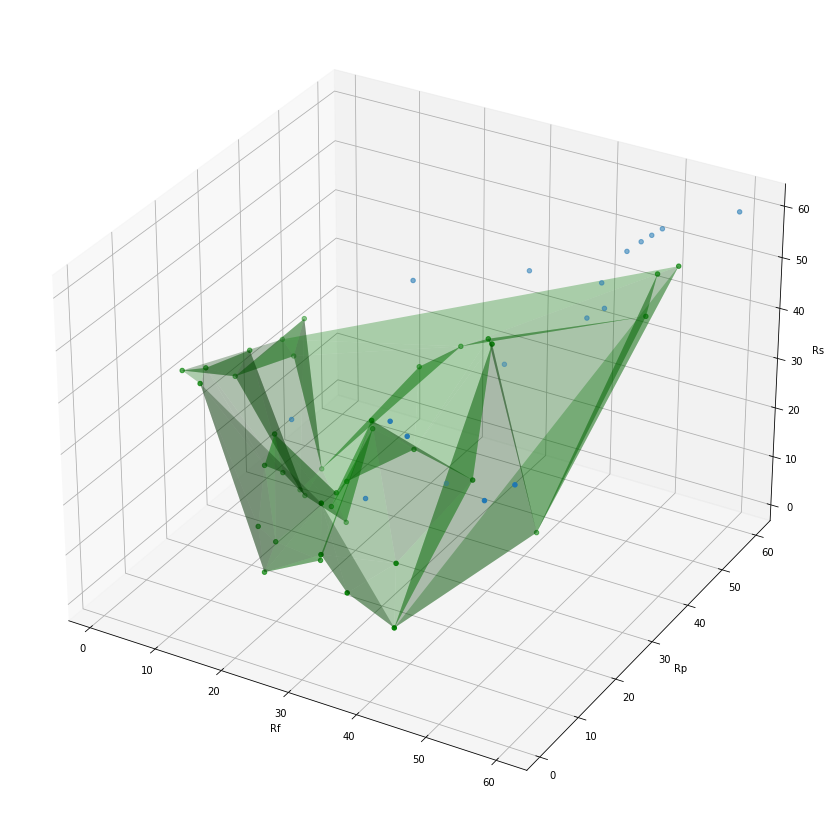

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



fig = plt.figure()
fig.set_size_inches(15, 15)
ax = fig.add_subplot(111, projection='3d')
dp = np.array(list(dominatedPoints))
pp = np.array(list(paretoPoints))

print(pp.shape,dp.shape)
ax.scatter(dp[:,0],dp[:,1],dp[:,2])
ax.scatter(pp[:,0],pp[:,1],pp[:,2],color='green')


ax.set_xlabel('Rf')
ax.set_ylabel('Rp')
ax.set_zlabel('Rs')




import matplotlib.tri as mtri
triang = mtri.Triangulation(pp[:,0],pp[:,1])
ax.plot_trisurf(triang,pp[:,2],color='green',alpha=0.3)
plt.show()

In [27]:
# CREATE DICTIONARY WITH RANKS AS KEY AND INDEX AS VALUE
def getConfs(points,orignaldf):
  point_confs = {}
  for i in range(0, len(orignaldf)):
    for val in points:
      if (list(val)==np.array(orignaldf[i][1:], dtype=np.float64).tolist()):
        point_confs[val]=orignaldf[i][0]

  return point_confs

In [28]:
def getConfsSorted(confsDict):  
  # # summing all the values using sum()
  temp1 = {val: np.sum(float(idx) for idx in val) 
            for val, key in confsDict.items()} #sum the ranks of non dominated solution
        
  # using sorted to perform sorting as required
  temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]],reverse=False) #sort according to the sum before
  res={}
  for key, val in temp2:
    res[key]=confsDict[key]

  #print("The sorted dictionary : " + str(res))
  return res

In [30]:
pareto = getConfs(paretoPoints, dimensionsAll)
pareto = getConfsSorted(pareto)
pareto

/var/folders/2p/1d3_p7wn1_7brj7yrtrpryw40000gn/T/ipykernel_2594/3544500913.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp1 = {val: np.sum(float(idx) for idx in val)


{(30.0,
  5.0,
  18.0,
  1.0,
  4.0,
  1.0,
  25.0,
  1.0,
  1.0,
  60.0,
  60.0): 'orc_wpt_subject',
 (43.0,
  1.0,
  12.0,
  4.0,
  2.0,
  2.0,
  24.0,
  3.0,
  3.0,
  60.0,
  60.0): 'parquet_wpt_subject',
 (12.0,
  25.0,
  13.0,
  46.0,
  8.0,
  11.0,
  5.0,
  34.0,
  44.0,
  19.0,
  2.0): 'parquet_vt_subject',
 (35.0,
  3.0,
  14.0,
  5.0,
  3.0,
  3.0,
  27.0,
  4.0,
  5.0,
  60.0,
  60.0): 'orc_wpt_horizontal',
 (19.0,
  9.0,
  7.0,
  32.0,
  11.0,
  14.0,
  42.0,
  19.0,
  8.0,
  2.0,
  60.0): 'parquet_extvt_subject',
 (32.0,
  2.0,
  31.0,
  2.0,
  1.0,
  4.0,
  28.0,
  2.0,
  6.0,
  60.0,
  60.0): 'parquet_wpt_horizontal',
 (44.0,
  36.0,
  6.0,
  16.0,
  17.0,
  10.0,
  19.0,
  10.0,
  20.0,
  30.0,
  22.0): 'avro_pt_subject',
 (15.0,
  14.0,
  11.0,
  33.0,
  6.0,
  20.0,
  46.0,
  17.0,
  7.0,
  1.0,
  60.0): 'parquet_extvt_horizontal',
 (11.0,
  32.0,
  3.0,
  11.0,
  13.0,
  6.0,
  17.0,
  6.0,
  13.0,
  60.0,
  60.0): 'parquet_pt_subject',
 (18.0,
  31.0,
  1.0,
  15.0,


In [29]:
dominated=getConfs(dominatedPoints, dimensionsAll)
dominated = getConfsSorted(dominated)
dominated

/var/folders/2p/1d3_p7wn1_7brj7yrtrpryw40000gn/T/ipykernel_2594/3544500913.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp1 = {val: np.sum(float(idx) for idx in val)


{(27.0,
  42.0,
  5.0,
  20.0,
  14.0,
  9.0,
  21.0,
  9.0,
  17.0,
  60.0,
  60.0): 'avro_pt_horizontal',
 (33.0,
  11.0,
  26.0,
  43.0,
  21.0,
  26.0,
  53.0,
  24.0,
  11.0,
  7.0,
  60.0): 'avro_extvt_predicate',
 (56.0,
  8.0,
  40.0,
  3.0,
  18.0,
  16.0,
  29.0,
  12.0,
  22.0,
  60.0,
  60.0): 'avro_wpt_subject',
 (16.0,
  21.0,
  28.0,
  53.0,
  31.0,
  33.0,
  12.0,
  49.0,
  52.0,
  29.0,
  8.0): 'parquet_vt_predicate',
 (34.0,
  45.0,
  30.0,
  13.0,
  33.0,
  43.0,
  36.0,
  40.0,
  33.0,
  15.0,
  15.0): 'orc_st_horizontal',
 (54.0,
  4.0,
  39.0,
  6.0,
  34.0,
  31.0,
  31.0,
  13.0,
  23.0,
  60.0,
  60.0): 'avro_wpt_horizontal',
 (42.0,
  6.0,
  45.0,
  7.0,
  38.0,
  36.0,
  30.0,
  15.0,
  27.0,
  60.0,
  60.0): 'csv_wpt_subject',
 (39.0,
  7.0,
  46.0,
  8.0,
  40.0,
  37.0,
  32.0,
  16.0,
  26.0,
  60.0,
  60.0): 'csv_wpt_horizontal',
 (45.0,
  47.0,
  42.0,
  19.0,
  47.0,
  44.0,
  39.0,
  42.0,
  37.0,
  31.0,
  20.0): 'avro_st_subject',
 (47.0,
  48.0,
  

In [5]:
import numpy as np
dictionary = {(27.0,
  44.0,
  34.0,
  12.0,
  34.0,
  46.0,
  38.0,
  47.0,
  34.0,
  22.0,
  16.0): 'parquet_st_horizontal',
  (28.0,
  29.0,
  22.0,
  9.0,
  26.0,
  39.0,
  32.0,
  32.0,
  30.0,
  8.0,
  14.0): 'orc_st_subject'}

temp1 = {val: sum(val) 
          for val, key in dictionary.items()}

temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]],reverse=False)

res={}
for key, val in temp2:
  res[key]=dictionary[key]

temp1

{(27.0, 44.0, 34.0, 12.0, 34.0, 46.0, 38.0, 47.0, 34.0, 22.0, 16.0): 354.0,
 (28.0, 29.0, 22.0, 9.0, 26.0, 39.0, 32.0, 32.0, 30.0, 8.0, 14.0): 269.0}

In [99]:
test = {"satu", "dua", "tiga"}

In [62]:
np.sum([test[x] <= test2[x] for x in range(5)]) == len(test)

False

In [102]:
print(test)

{'dua', 'tiga', 'satu'}
